In [1]:
ours2orig = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 254, 41, 42, 43, 44, 45,
46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 85,
86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103,
104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 136, 138, 132,
133, 134, 135, 220, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 185, 186,
187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201,
202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216,
217, 218, 219, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232,
233, 137, 234, 235, 236, 237, 238, 239, 240, 241, 250, 251, 255, 256, 257,
258, 259, 260, 261, 262, 263, 242, 243, 244, 245, 0, 1, 2, 3, 4, 5, 6, 7, 8,
9, 10, 11, 83, 84, 131, 139, 140, 141, 181, 182, 183, 184, 246, 247, 248,
249, 252, 253]

def vec2mat(v):
    a,b = np.triu_indices(264,1)
    m = np.zeros((264,264))
    m[a,b] = v
    return m+m.T

def remap(fc, roimap=ours2orig):
    fc = fc[roimap,:]
    fc = fc[:,roimap]
    return fc

print('Complete')

Complete


In [2]:
# Load AE model

import torch
import torch.nn as nn
import torch.nn.functional as F

class AE(nn.Module):
    def __init__(self, ld, rank):
        super(AE, self).__init__()
        self.rank = rank
        self.enc1 = nn.Linear(34716, ld).float().cuda()
        self.dec1 = nn.Linear(ld, rank*264).float().cuda()

    def enc(self, x):
        return self.enc1(x)

    def dec(self, x):
        y = self.dec1(x)
        y = y.reshape(x.shape[0], 264, self.rank)
        y = torch.einsum('nab,ncb->nac', y, y)
        return y

    def decvec(self, x):
        y = self.dec(x)
        a,b = np.triu_indices(264,1)
        y = y[:,a,b]
        return y

ae = AE(2000, 10)
ae.load_state_dict(torch.load('/home/anton/Documents/Tulane/Research/ImageNomer/data/PNC/lat2000_rank10_ae.torch'))
ae.eval()

print(ae.rank)
print(ae.enc1.weight.shape)

10
torch.Size([2000, 34716])


In [3]:
class Gen(nn.Module):
    def __init__(self, ld, nd):
        super(Gen, self).__init__()
        self.nd = nd
        self.enc1 = nn.Linear(8+nd, 100).float().cuda()
        self.enc2 = nn.Linear(100, ld).float().cuda()

    def forward(self, n, ag, sx, rc, rst, nbk, emd, rand=None):
        if rand is None:
            x = torch.normal(0, 1, size=(n, self.nd)).float().cuda()
        else:
            x = rand
        x = torch.cat([x, torch.ones(n, 1).float().cuda()*ag, 
                       torch.ones(n, 1).float().cuda()*sx, 
                       torch.ones(n, 1).float().cuda()*(1-sx),
                       torch.ones(n, 1).float().cuda()*rc, 
                       torch.ones(n, 1).float().cuda()*(1-rc),
                       torch.ones(n, 1).float().cuda()*rst,
                       torch.ones(n, 1).float().cuda()*nbk,
                       torch.ones(n, 1).float().cuda()*emd], dim=1)
        x = F.relu(self.enc1(x))
        x = self.enc2(x)
        return x

ce = nn.CrossEntropyLoss()

def latToVec(ae, z):
    p = ae.decvec(z)
    return p

def clamp(disc, a):
    with torch.no_grad():
        disc.fc1.weight[disc.fc1.weight > a] = a
        disc.fc1.weight[disc.fc1.weight < -a] = -a
        disc.fc2.weight[disc.fc2.weight > a] = a
        disc.fc2.weight[disc.fc2.weight < -a] = -a

class Disc(nn.Module):
    def __init__(self):
        super(Disc, self).__init__()
        self.fc1 = nn.Linear(34716, 50).float().cuda()
        self.fc2 = nn.Linear(50, 2).float().cuda()

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def rmse(a, b):
    return torch.mean((a-b)**2)**0.5

def pretty(x):
    return f'{round(float(x), 4)}'

gen = Gen(2000, 20)

gen.load_state_dict(torch.load('/home/anton/Documents/Tulane/Research/ImageNomer/data/PNC/lat2000_gen_20+8.torch'))
gen.eval()

Gen(
  (enc1): Linear(in_features=28, out_features=100, bias=True)
  (enc2): Linear(in_features=100, out_features=2000, bias=True)
)

In [4]:
# Load FC

import pickle
import numpy as np

pncdir = '/home/anton/Documents/Tulane/Research/data-sav/anton/cohorts/PNC/'
lowrankdir = '/home/anton/Documents/Tulane/Research/Work/ContrastiveLearning/PNC/Top10/'
pncdemo = pickle.load(open(f'{pncdir}/demographics.pkl', 'rb'))
no_snps_subs = pickle.load(open('/home/anton/Documents/Tulane/Research/ImageNomer/data/PNC/fc_subs_no_snps.pkl', 'rb'))

rest = []
nback = []
emoid = []
restmat = []
nbackmat = []
emoidmat = []
race = []
sex = []
age = []
subids = []

a,b = np.triu_indices(264,1)

for sub in pncdemo['age_at_cnb']:
    if sub in no_snps_subs:
        continue
    try:
        ra = pncdemo['Race'][sub]
        ag = pncdemo['age_at_cnb'][sub]
        se = pncdemo['Sex'][sub]
        if ra not in ['AA', 'EA']:
            continue
        ra = ra == 'AA'
        se = se == 'M'
        r = np.load(f'{lowrankdir}/{sub}_task-resttop10_fc.npy')
        n = np.load(f'{lowrankdir}/{sub}_task-nbacktop10_fc.npy')
        e = np.load(f'{lowrankdir}/{sub}_task-emoidtop10_fc.npy')
        r = remap(vec2mat(r))
        n = remap(vec2mat(n))
        e = remap(vec2mat(e))
        race.append(ra)
        sex.append(se)
        age.append(ag)
        rest.append(r[a,b])
        nback.append(n[a,b])
        emoid.append(e[a,b])
        restmat.append(r)
        nbackmat.append(n)
        emoidmat.append(e)
        subids.append(sub)
    except:
        pass

rest = np.stack(rest)
nback = np.stack(nback)
emoid = np.stack(emoid)
restmat = np.stack(restmat)
nbackmat = np.stack(nbackmat)
emoidmat = np.stack(emoidmat)
race = np.array(race).astype('int')
sex = np.array(sex).astype('int')
age = np.array(age)

print([a.shape for a in [rest, nback, emoid, restmat, nbackmat, emoidmat, race, sex, age]])

[(1155, 34716), (1155, 34716), (1155, 34716), (1155, 264, 264), (1155, 264, 264), (1155, 264, 264), (1155,), (1155,), (1155,)]


In [6]:
# Load small SNPs

snps = []
no_snps_subs = []

snps_file = pickle.load(open('/home/anton/Documents/Tulane/Research/ImageNomer/data/PNC/snps_all_subs_small.pkl', 'rb'))

for sub in subids:
    if sub not in snps_file:
        print(sub)
        # no_snps_subs.append(sub)
    snps.append(snps_file[sub])

snps = np.stack(snps)
snps[np.isnan(snps)] = 0

print(snps.shape)

# pickle.dump(no_snps_subs, open('/home/anton/Documents/Tulane/Research/ImageNomer/data/PNC/fc_subs_no_snps.pkl', 'wb'))

# print('Done')

(1155, 10433)


In [7]:
# Simple InfoNCE with three positive samples and random negative from all others

class SnpsEnc(nn.Module):
    def __init__(self, ld, snpsd):
        super(SnpsEnc, self).__init__()
        self.enc1 = nn.Linear(snpsd, 500).float().cuda()
        self.enc2 = nn.Linear(500, ld).float().cuda()

    def forward(self, x):
        x = F.relu(self.enc1(x))
        x = self.enc2(x)
        return x

# ce = nn.CrossEntropyLoss()

# def nce_loss(x, pos, neg):
#     np = len(pos)
#     nn = len(neg)
#     y = torch.cat([pos, neg])
#     x = x.unsqueeze(0).tile(len(y))
#     sim = F.cosine_similarity(x,y)
#     logits = F.softmax(sim)
#     tgt = torch.cat([torch.ones(np), torch.zeros(neg)]).long().cuda()
#     loss = ce(logits, tgt)
#     return loss

rt = torch.from_numpy(rest).float().cuda()
nt = torch.from_numpy(nback).float().cuda()
et = torch.from_numpy(emoid).float().cuda()
snpst = torch.from_numpy(snps).float().cuda()

senc = SnpsEnc(20, snpst.shape[1])
optim = torch.optim.Adam(senc.parameters(), lr=1e-4, weight_decay=1e-4)

nepochs = 1000
pperiod = 20
bsize = 20

for e in range(nepochs):
    optim.zero_grad()
    btidcs = np.random.permutation(len(rt))[:bsize]
    rtb = rt[btidcs]
    ntb = nt[btidcs]
    etb = et[btidcs]
    ab = age[btidcs]
    sb = sex[btidcs]
    rb = race[btidcs]
    lossr = 0
    lossn = 0
    losse = 0
    for i in range(bsize):
        lat = senc(snpst[btidcs[i:i+1]])
        rlat = gen(1, ab[i], sb[i], rb[i], 1, 0, 0, lat)
        rhat = ae.decvec(rlat)
        lossr += rmse(rhat, rtb[i:i+1])
        nlat = gen(1, ab[i], sb[i], rb[i], 0, 1, 0, lat)
        nhat = ae.decvec(nlat)
        lossn += rmse(rhat, ntb[i:i+1])
        elat = gen(1, ab[i], sb[i], rb[i], 0, 0, 1, lat)
        ehat = ae.decvec(elat)
        losse += rmse(rhat, etb[i:i+1])
    (lossr+lossn+losse).backward()
    optim.step()
    if e%pperiod == 0 or e == nepochs-1:
        print(f'{e} {pretty(lossr/bsize)} {pretty(lossn/bsize)} {pretty(losse/bsize)}')

print('Done')

0 0.3134 0.253 0.2771
20 0.2354 0.2143 0.2298
40 0.2332 0.2097 0.2469
60 0.2385 0.2084 0.2257
80 0.2255 0.2161 0.2318
100 0.2598 0.2223 0.2356
120 0.2365 0.2132 0.2205
140 0.2212 0.2074 0.2072
160 0.2541 0.2238 0.2361
180 0.231 0.2175 0.225
200 0.246 0.1983 0.2082
220 0.2446 0.2196 0.2066
240 0.2421 0.2109 0.2341
260 0.2258 0.2074 0.2296
280 0.2308 0.2181 0.2315
300 0.2485 0.2162 0.2304
320 0.2348 0.2179 0.2294
340 0.2341 0.213 0.2191
360 0.2465 0.2129 0.2117
380 0.2343 0.2166 0.2186
400 0.2531 0.2081 0.2168
420 0.2401 0.2277 0.231
440 0.2299 0.1985 0.2142
460 0.2334 0.2191 0.2216
480 0.2404 0.2117 0.2117
500 0.2404 0.2163 0.2391
520 0.2279 0.2131 0.2244
540 0.2473 0.217 0.2139
560 0.2351 0.212 0.2112
580 0.244 0.2003 0.2197
600 0.233 0.21 0.2193
620 0.2445 0.202 0.2141
640 0.2163 0.2237 0.2299
660 0.2374 0.2089 0.2186
680 0.2259 0.2122 0.2131
700 0.2333 0.1995 0.2123
720 0.2439 0.2148 0.2252
740 0.2361 0.2001 0.2099
760 0.2446 0.2229 0.2286
780 0.2387 0.2016 0.2085
800 0.2338 0.2026 0

/tmp/ipykernel_53825/3527155484.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


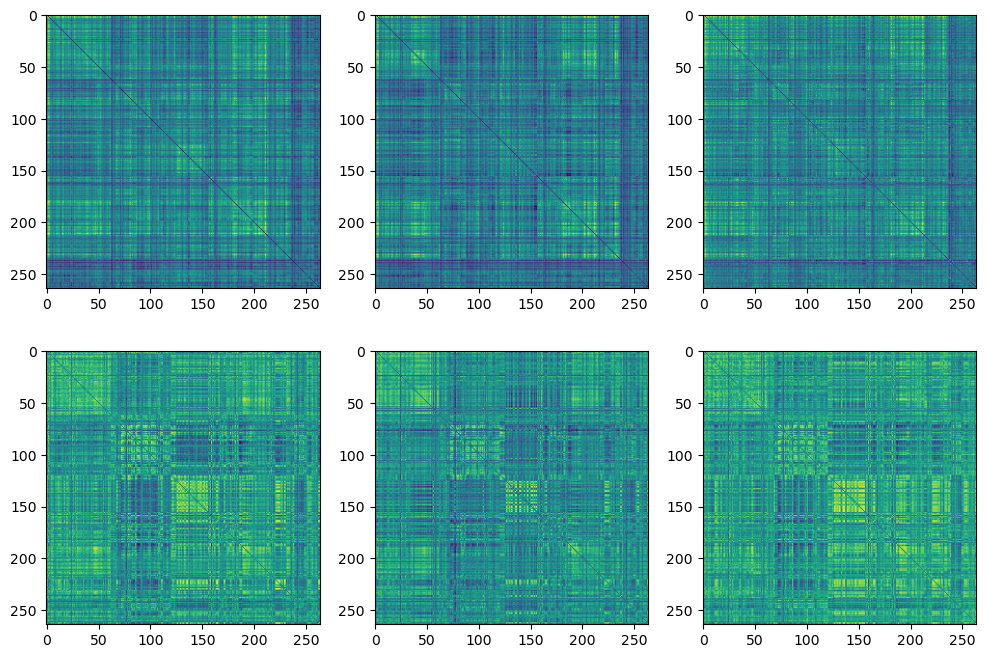

In [30]:
import matplotlib.pyplot as plt
import random

with torch.no_grad():
    idx = random.randint(0, len(rt))
    ag = age[idx]
    sx = sex[idx]
    rc = race[idx]
    lat = senc(snpst[idx:idx+1])
    rhat = ae.decvec(gen(1, ag, sx, rc, 1, 0, 0, lat))[0]*2
    nhat = ae.decvec(gen(1, ag, sx, rc, 0, 1, 0, lat))[0]*2
    ehat = ae.decvec(gen(1, ag, sx, rc, 0, 0, 1, lat))[0]*2
    # rhat = ae.decvec(lat)[0]
    # nhat = ae.decvec(lat)[0]
    # ehat = ae.decvec(lat)[0]
    rhat[rhat > 1] = 1
    rhat[rhat < -1] = -1
    nhat[ehat > 1] = 1
    nhat[ehat < -1] = -1
    ehat[ehat > 1] = 1
    ehat[ehat < -1] = -1
    rtru = rt[idx]
    ntru = nt[idx]
    etru = et[idx]

fig, ax = plt.subplots(2,3,figsize=(12,8))
ax[0,0].imshow(vec2mat(rhat.detach().cpu().numpy()))
ax[0,1].imshow(vec2mat(nhat.detach().cpu().numpy()))
ax[0,2].imshow(vec2mat(ehat.detach().cpu().numpy()))
ax[1,0].imshow(vec2mat(rtru.detach().cpu().numpy()))
ax[1,1].imshow(vec2mat(ntru.detach().cpu().numpy()))
ax[1,2].imshow(vec2mat(etru.detach().cpu().numpy()))
fig.show()